# Question 1.1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

In [2]:
df = pd.read_csv('./A1_co2.txt', sep=' ')
df.head()

,year,month,time,co2
0,1958,3,1958.208,315.71
1,1958,4,1958.292,317.45
2,1958,5,1958.375,317.50
3,1958,6,1958.458,317.10
4,1958,7,1958.542,315.86


> You should not use the observations for years 2018 and 2019 (Last 20 observations) for estimations/training - only for comparisons/testing.

In [3]:
# Let the train set be the measurements before 2018, and the test set be the measurements after 2018
train = df[df['year'] < 2018]
test = df[df['year'] >= 2018]

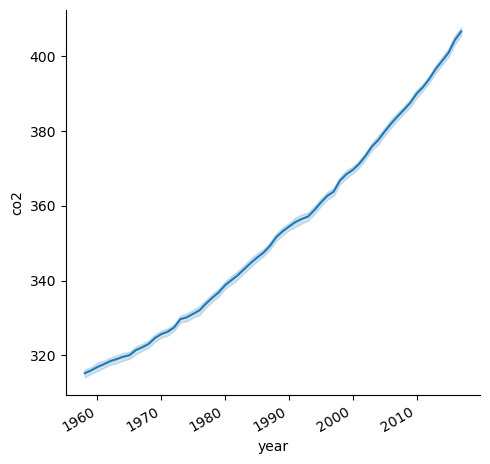

In [4]:
# TODO: Plot test and train set together

# Plot the train set
g = sns.relplot(x="year", y="co2", kind="line", data=train)
g.fig.autofmt_xdate()


# Question 1.2

## Question 1.2.1

In [5]:
MONTHS_IN_YEAR = 12

X = np.vstack(
    [
        np.ones_like(train["time"]),
        train["time"],
        np.sin(2 * np.pi * train["time"]),
        np.cos(2 * np.pi * train["time"]),
    ]
).T

In [6]:
y = train["co2"].values

In [7]:
beta_hat, _, _, _ = np.linalg.lstsq(X, y)
beta_hat

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_80350/2767225113.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta_hat, _, _, _ = np.linalg.lstsq(X, y)


array([-2.70966963e+03,  1.54048879e+00,  2.61380268e+00, -1.05019446e+00])

## Question 1.2.2

In [8]:
N, p = X.shape

residuals = y - X @ beta_hat

sigma_hat2 = np.sum(residuals ** 2) / (N - p)
sigma_hat2

12.185302051401825

In [9]:
beta_hat_var = sigma_hat2 * np.linalg.inv(X.T @ X)
beta_hat_var

array([[ 2.24888020e+02, -1.13109468e-01, -2.72928405e-02,
         1.58527076e-02],
       [-1.13109468e-01,  5.68937260e-05,  1.37512899e-05,
        -7.93399876e-06],
       [-2.72928405e-02,  1.37512899e-05,  3.39051503e-02,
         6.93784430e-05],
       [ 1.58527076e-02, -7.93399876e-06,  6.93784430e-05,
         3.39848610e-02]])

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_80350/985155053.py:2: RuntimeWarning: invalid value encountered in sqrt
  sns.heatmap(np.sqrt(beta_hat_var), annot=True, fmt=".2f")


<AxesSubplot: >

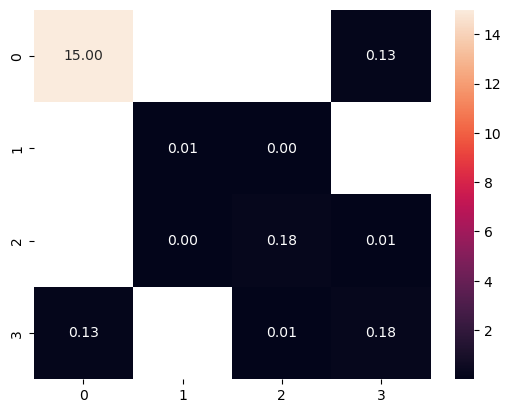

In [10]:
# Heatmap of the variance of the coefficients
sns.heatmap(np.sqrt(beta_hat_var), annot=True, fmt=".2f")

In [11]:
sigma_hat2

12.185302051401825

## Question 1.2.3

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_80350/2672438754.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


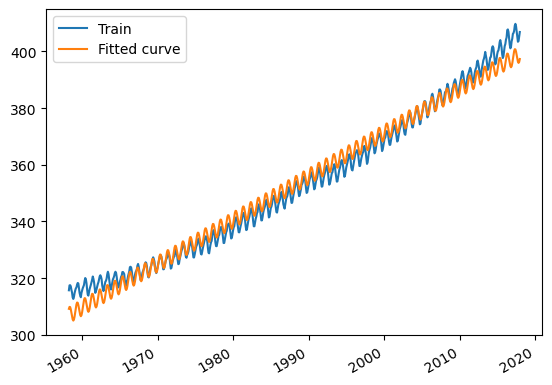

In [12]:
y_hat = X @ beta_hat

# Plot the train set and the fitted curve
fig, ax = plt.subplots()

ax.plot(train["time"], train["co2"], label="Train")
ax.plot(train["time"], y_hat, label="Fitted curve")

ax.legend()

fig.autofmt_xdate()
fig.show()

## Question 1.2.4

Plan-of-attack: Relaxtion algorithm

In [13]:
def rho_matrix(rho: float, n: int):
    """
    Returns the covariance matrix for the observations of a stationary AR(1) process.
    """
    rhos = np.vander([rho], n, increasing=True)
    return scipy.linalg.toeplitz(rhos)


N, p = X.shape

# Initial guess of correlation structure
Sigma = np.eye(N)

# Initial guess of coefficients
beta = beta_hat

betas = []

for _ in range(6):
    # E-step
    Sigma_inv = np.linalg.inv(Sigma)

    H = np.linalg.inv(X.T @ Sigma_inv @ X) @ X.T @ Sigma_inv

    beta_new = H @ y

    # M-step
    residuals = y - X @ beta_new

    rho = np.corrcoef(residuals[:-1], residuals[1:])[0, 1]
    
    Sigma_new = rho_matrix(rho, N)

    # Print the difference between the old and new estimates
    #print(np.linalg.norm(beta - beta_new), np.linalg.norm(Sigma - Sigma_new))

    #if np.allclose(beta, beta_new, atol=1e-6) and np.allclose(Sigma, Sigma_new, atol=1e-6):
    #   break

    beta = beta_new
    Sigma = Sigma_new

    betas.append(beta)

beta

array([-2.74397922e+03,  1.55828379e+00,  2.64772003e+00, -1.01879474e+00])

In [14]:
rho

0.9822406473546076

## Question 1.2.6

In [15]:
# Calculate the variance of the coefficients
print(sigma_hat2) # 9.869839697476767
sigma_hat2 = (residuals.T @ np.linalg.inv(Sigma) @ residuals ) / (N - p - 1)
print(sigma_hat2)
beta_var = np.linalg.inv(X.T @ np.linalg.inv(Sigma) @ X) * sigma_hat2
beta_var

12.185302051401825
12.287819043442582


array([[ 1.65080927e+04, -8.30268911e+00, -6.77904773e-02,
         3.84429243e-02],
       [-8.30268911e+00,  4.17622801e-03,  3.39930953e-05,
        -1.95199988e-05],
       [-6.77904773e-02,  3.39930953e-05,  4.58491017e-03,
        -1.10721169e-05],
       [ 3.84429243e-02, -1.95199988e-05, -1.10721169e-05,
         4.57183937e-03]])

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_80350/3024580176.py:1: RuntimeWarning: invalid value encountered in sqrt
  sns.heatmap(np.sqrt(beta_var), annot=True, fmt=".2f")


<AxesSubplot: >

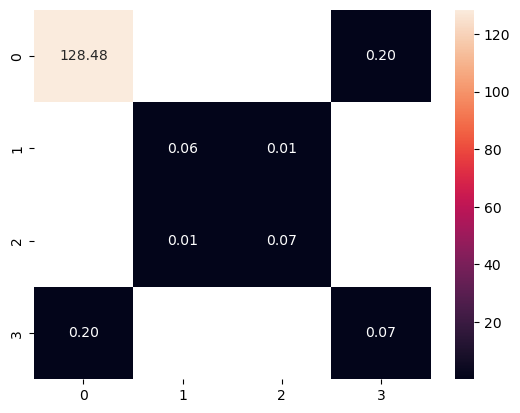

In [16]:
sns.heatmap(np.sqrt(beta_var), annot=True, fmt=".2f")

In [17]:
beta_hat - beta

array([ 3.43095924e+01, -1.77949907e-02, -3.39173582e-02, -3.13997169e-02])

## Question 1.2.7

/var/folders/p_/6wwjz4v11fs26vb5j8zwskgm0000gn/T/ipykernel_80350/1449667870.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


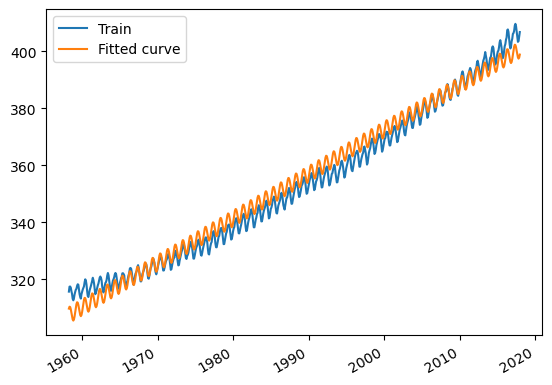

In [18]:
y_hat = X @ beta

# Plot the train set and the fitted curve
fig, ax = plt.subplots()

ax.plot(train["time"], train["co2"], label="Train")
ax.plot(train["time"], y_hat, label="Fitted curve")

ax.legend()

fig.autofmt_xdate()
fig.show()